# DAND Final project: Bike sharing 

# Explanatory Presentation  
#### part of Udacity Data Analyst formation, May 2020, v3

##### By Mauricio Cabreira

# Overview 
Bay Area Bike Share (now Ford GoBike) provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. 

Users can unlock bikes from various stations throughout each city, and return them to any station within the same city. Clients pay for the service either through a yearly subscription or by purchasing a 24-hour or 3-day pass. Under service conditions, they can make an unlimited number of trips: trips under thirty minutes in length have no additional charge, longer trips will incur overtime fees.

**Users that pay the subscription and have unlimmited rides in the period are identified as "Subscribers". Users that purchase the 1 or 3 days passes, are called "Customers".**

The data and details of the service can be founde here: https://www.lyft.com/bikes/bay-wheels/system-data

# Introduction

**In this analysis we will explore all the rides from 2019.**

This presentation will guide you through some visuals in order to show you some relevant information about the service.

The information shown can be of use to general public, and also to the owner of the service or the marketing teams, in order to provide few insights about how the service is used in order to allow plans to expansion of stations and user's growth.


### The presentation structure:

- How many rides were done in 2019? What is the average per day? Which user rides most?

- What are the month/days/hours each subscriber rides most? Are the any differences about each user profile?

- What are the most common ride durations? And distances? Is there a difference on the Subscriber and Customer profiles? If so, what is it?

- What are the busiest bike stations?


# Let's find out together

In [223]:
#Import needed packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy 
import time
import json 
import seaborn as sns
import math 
from datetime import datetime
from functools import reduce

In [224]:
#reading the file, so Analyst does not have to run all the processes above to query.
df_2019 = pd.read_csv('./data/2019_lyft_bike_sharing_rides.csv') 
df_2019.head(1)

,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,distance_km,duration_min,hour_of_the_day,day_of_the_week,month,day
0,2019-01-31 22:35:50,2019-02-01 00:28:04,245.0,Downtown Berkeley BART,37.870139,-122.268422,266.0,Parker St at Fulton St,37.862464,-122.264791,3532,Subscriber,0.9,112.22,22,Thu,Jan,31


In [225]:
#convert date to datetime
df_2019['start_time']= pd.to_datetime(df_2019['start_time']) 
df_2019['end_time']= pd.to_datetime(df_2019['end_time']) 


In [226]:
df_2019.shape

(2337862, 18)

In [227]:
rides_per_day = df_2019.shape[0]/365
rides_per_day

6405.101369863014

In [228]:
df_2019.groupby('user_type').user_type.count()

user_type
Customer       439872
Subscriber    1897990
Name: user_type, dtype: int64

In [229]:
round(df_2019.groupby('user_type').user_type.count()[0] / df_2019.shape[0], 2)

0.19

In [230]:
round(df_2019.groupby('user_type').user_type.count()[1] / df_2019.shape[0], 2)

0.81

## 1

# There were 2.33M rides in 2019, about 6.4K rides per day!

An average of 7138 rides on Mondays, 7720 on Tuesdays, 7549 on Wednesdays, 7741 on Thursdays, 7167 on Fridays.

On the weekends number of rides dropped to about 50-60% of week average.


### The split per user type is shown below:

## 2

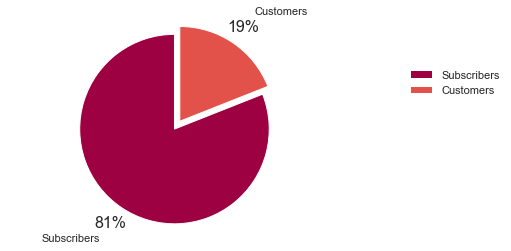

In [231]:
#PIE chart - % of rides per day of week.

fig, ax = plt.subplots()
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=16
labels = ['Subscribers', 'Customers']

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


percentages = [round(df_2019.groupby('user_type').user_type.count()[1] / df_2019.shape[0], 2),
               round(df_2019.groupby('user_type').user_type.count()[0] / df_2019.shape[0], 2)]
explode=(0,0.1)

#ax.pie(percentages, explode=explode, labels=labels, colors=color_palette_list[0:7],
ax.pie(percentages, explode=explode, labels=labels, colors=colors,
       autopct='%1.0f%%', 
       shadow=False, startangle=90,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
#ax.set_title("Trips during the week and weekends")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8));

## 3

In [232]:
df_subscriber_week =  df_2019.query('user_type == "Subscriber" & (day_of_the_week == "Mon" | day_of_the_week == "Tue" | day_of_the_week == "Wed" | day_of_the_week == "Thu" | day_of_the_week == "Fri" )')
df_customer_week =  df_2019.query('user_type == "Customer" & (day_of_the_week == "Mon" | day_of_the_week == "Tue" | day_of_the_week == "Wed" | day_of_the_week == "Thu" | day_of_the_week == "Fri" )')

df_subscriber_weekend =  df_2019.query('user_type == "Subscriber" & (day_of_the_week == "Sat" | day_of_the_week == "Sun" )')
df_customer_weekend =  df_2019.query('user_type == "Customer" & (day_of_the_week == "Sat" | day_of_the_week == "Sun" )')

df_subscriber_week.user_type.count(),  df_customer_week.user_type.count(), df_subscriber_weekend.user_type.count(), df_customer_weekend.user_type.count()





(1619529, 320941, 278461, 118931)

In [233]:
#Ratio week: almost 5x more subs than customer
df_subscriber_week.user_type.count() /  df_customer_week.user_type.count()

5.046189174957391

In [234]:
#Ratio weekend. on the weekend that falls to about 2x only..
df_subscriber_weekend.user_type.count() /  df_customer_weekend.user_type.count()

2.341366002135692

In [235]:
total_p_subscriber_week = (round(df_subscriber_week.user_type.count() / df_2019.query('day_of_the_week == "Mon" | day_of_the_week == "Tue" | day_of_the_week == "Wed" | day_of_the_week == "Thu" | day_of_the_week == "Fri"').user_type.count(), 2))*100
total_p_customer_week = (round(df_customer_week.user_type.count() / df_2019.query('day_of_the_week == "Mon" | day_of_the_week == "Tue" | day_of_the_week == "Wed" | day_of_the_week == "Thu" | day_of_the_week == "Fri" ').user_type.count(), 2))*100

total_p_subscriber_weekend = (round(df_subscriber_weekend.user_type.count() / df_2019.query('day_of_the_week == "Sat" | day_of_the_week == "Sun"').user_type.count(), 2))*100
total_p_customer_weekend = (round(df_customer_weekend.user_type.count() / df_2019.query('day_of_the_week == "Sat" | day_of_the_week == "Sun" ').user_type.count(), 2))*100

total_p_subscriber_week, total_p_customer_week, total_p_subscriber_weekend, total_p_customer_weekend

(83.0, 17.0, 70.0, 30.0)

In [236]:
total_subscriber_rides_week = df_2019.query('day_of_the_week == "Mon" | day_of_the_week == "Tue" | day_of_the_week == "Wed" | day_of_the_week == "Thu" | day_of_the_week == "Fri"').user_type.count()


In [237]:
total_subscriber_rides_weekend = df_2019.query('day_of_the_week == "Sat" | day_of_the_week == "Sun"').user_type.count()



In [238]:
total_rides_mon = df_2019.query('day_of_the_week == "Mon"').user_type.count()
total_rides_tue = df_2019.query('day_of_the_week == "Tue"').user_type.count()
total_rides_wed = df_2019.query('day_of_the_week == "Wed"').user_type.count()
total_rides_thu = df_2019.query('day_of_the_week == "Thu"').user_type.count()
total_rides_fri = df_2019.query('day_of_the_week == "Fri"').user_type.count()
total_rides_sat = df_2019.query('day_of_the_week == "Sat"').user_type.count()
total_rides_sun = df_2019.query('day_of_the_week == "Sun"').user_type.count()




In [239]:
total_rides_mon / 52, total_rides_tue /52 , total_rides_wed/52 ,total_rides_thu/52 ,total_rides_fri/52,total_rides_sat /52,total_rides_sun/52 




(7138.115384615385,
 7720.75,
 7549.153846153846,
 7741.2692307692305,
 7167.442307692308,
 4021.980769230769,
 3620.173076923077)

In [240]:
total_rides = df_2019.user_type.count()



# How is the ride distribution over the week?

### Number of rides are pretty much similar from Mon to Fri, descreasing on the weekend to Subscribers (from 83% to 68% of the rides). 

### For the Customers, the opposite happens. Ride volume increase from 17% over the week to 32% on the weekends! It seems Customers are visitors indeed! 


(Hit DOWN key)

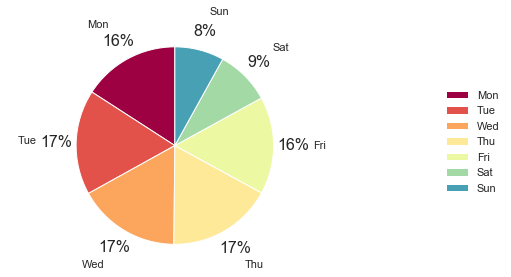

In [241]:
#PIE chart - % of rides per day of week.


fig, ax = plt.subplots()
#plt.rcParams['font.sans-serif'] = 'Arial'
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=16
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9','#C1F0F6', '#0099CC', '#66b3ff']

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


percentages = [df_2019.query('day_of_the_week == "Mon"').month.count()/total_rides, 
               df_2019.query('day_of_the_week == "Tue"').month.count()/total_rides,
               df_2019.query('day_of_the_week == "Wed"').month.count()/total_rides,
               df_2019.query('day_of_the_week == "Thu"').month.count()/total_rides,
               df_2019.query('day_of_the_week == "Fri"').month.count()/total_rides,
               df_2019.query('day_of_the_week == "Sat"').month.count()/total_rides,
               df_2019.query('day_of_the_week == "Sun"').month.count()/total_rides]
explode=(0.,0.,0.,0.,0.,0.,0. )

#ax.pie(percentages, explode=explode, labels=labels, colors=color_palette_list[0:7],
ax.pie(percentages, explode=explode, labels=labels, colors=colors,
       autopct='%1.0f%%', 
       shadow=False, startangle=90,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
#ax.set_title("Trips during the week and weekends")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8));

## 4

# When looking at the number of rides each month:

(Hit DOWN key)

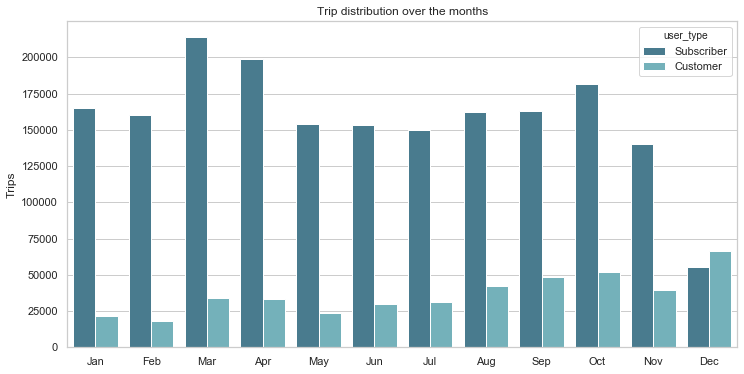

In [242]:
plt.figure(figsize = [12,6])
sns.set(style="whitegrid")



sns.countplot(x="month", hue='user_type', palette = "GnBu_d", 
              order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'], data = df_2019);


plt.title('Trip distribution over the months')
plt.ylabel('Trips');
plt.xlabel('');


## We can see that:

### In December the number of Customers reached its highest point in the year. Would that people visiting the city?

### On the Subscribers side though, December was the month where it reached the lowest peak. Would that mean that Subscribers are workers, and they are on leave?  


## Let's dig in further in the coming slides.

## 5

# Monday to Friday - What are the busiest times over the day? 

(Hit DOWN key)

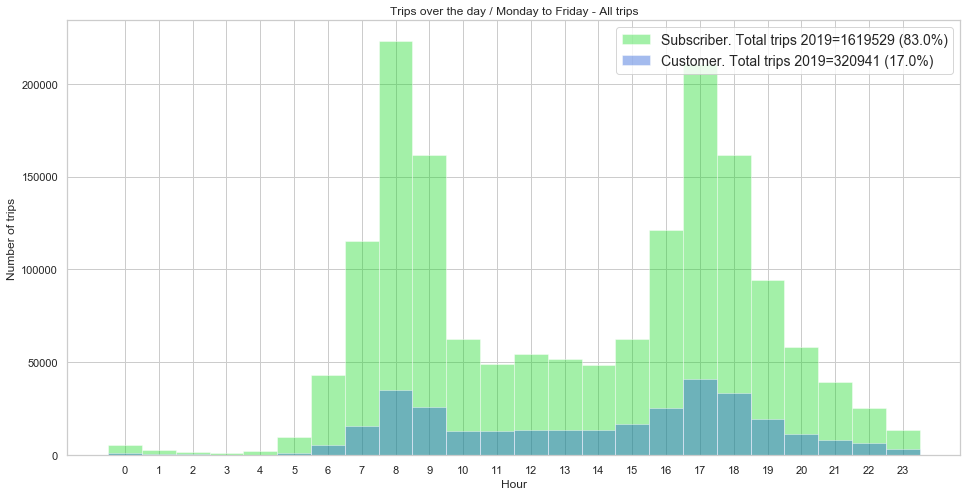

In [243]:
#trips over the day from midnight to 23h - WEEK
plt.figure(figsize = [16,8])


bin_edges = np.arange(-0.5, 23.5+1, 1)
sns.set(style="whitegrid")

#palette = iter(sns.husl_palette(2))

label_subscriber = "Subscriber. Total trips 2019=" + str(df_subscriber_week.user_type.count()) + " (" + str(total_p_subscriber_week) + "%)"
label_customer = "Customer. Total trips 2019=" + str(df_customer_week.user_type.count()) + " (" + str(total_p_customer_week) + "%)"

sns.distplot(df_subscriber_week['hour_of_the_day'], kde = False, color='#19DB26',label=label_subscriber, bins = bin_edges)
sns.distplot(df_customer_week['hour_of_the_day'],kde = False, color='#1C56D6', label=label_customer, bins = bin_edges)



plt.xticks(np.arange(0, 24, 1));
plt.legend(prop={'size': 14})
plt.title('Trips over the day / Monday to Friday - All trips')
plt.xlabel('Hour')
plt.ylabel('Number of trips');

### Graphic above shows two peaks: between 8-9am and 5-6pm, mainly from the Subscribers' rides. Are they  riding to work?

### See that Customers' rides volume keeps steady between 10am-2pm, as opposite to the Subscribers. Would that be visitors?

## 6

# Now, let's see how the rides are distributed over the weekends: 

(Hit DOWN key)

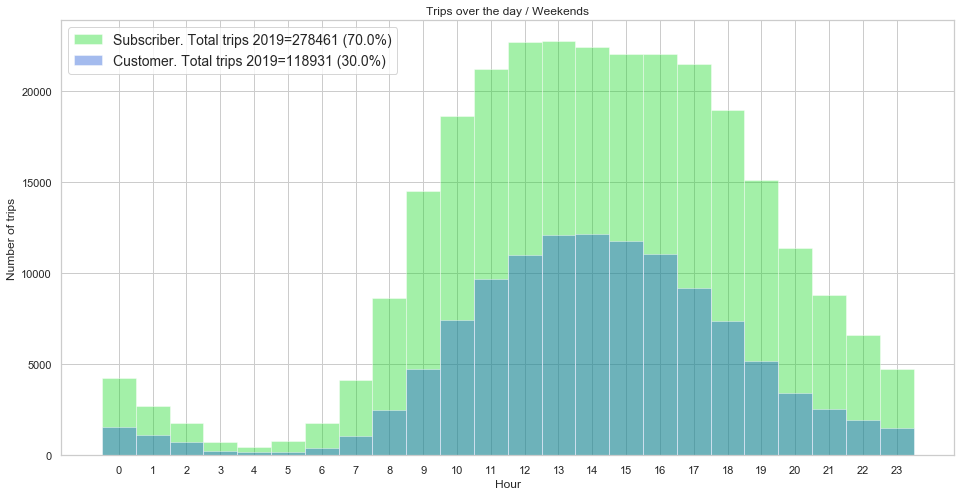

In [244]:
#trips over the day from midnight to 23h - WEEKEND
plt.figure(figsize = [16,8])

bin_edges = np.arange(-0.5, 23.5+1, 1)
sns.set(style="whitegrid")

label_subscriber = "Subscriber. Total trips 2019=" + str(df_subscriber_weekend.user_type.count()) + " (" + str(total_p_subscriber_weekend) + "%)"
label_customer = "Customer. Total trips 2019=" + str(df_customer_weekend.user_type.count()) + " (" + str(total_p_customer_weekend) + "%)"


sns.distplot(df_subscriber_weekend['hour_of_the_day'], kde = False, color='#19DB26', label=label_subscriber, bins = bin_edges)
sns.distplot(df_customer_weekend['hour_of_the_day'],kde = False,color='#1C56D6', label=label_customer, bins = bin_edges)

plt.xticks(np.arange(0, 24, 1));
plt.legend(prop={'size': 14})
plt.title('Trips over the day / Weekends')
plt.xlabel('Hour')
plt.ylabel('Number of trips');

## We can see above that the distribution is very different from the week days.

## The Subscriber and Customer behaviours are pretty much similar: peak is late morning until late noon, but people still riding until late night!

## 7

# The Duration of the rides. Let's check their variation 

(Hit DOWN key)

In [245]:
df_2019.query('user_type == "Subscriber"').duration_min.describe()

count    1.897990e+06
mean     1.063212e+01
std      8.405992e+00
min      1.520000e+00
25%      5.650000e+00
50%      8.800000e+00
75%      1.333000e+01
max      2.392500e+02
Name: duration_min, dtype: float64

In [246]:
df_2019.query('user_type == "Customer"').duration_min.describe()

count    439872.000000
mean         17.686554
std          19.471574
min           1.520000
25%           8.280000
50%          12.920000
75%          20.150000
max         239.980000
Name: duration_min, dtype: float64

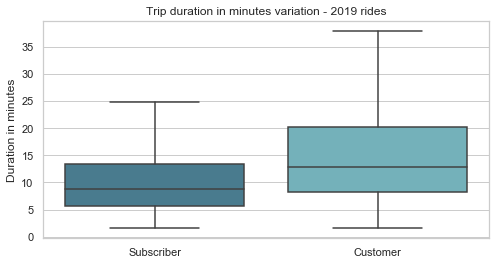

In [247]:
plt.figure(figsize = [8,4])

sns.set(style="whitegrid")
sns.boxplot(data = df_2019, x = 'user_type', y = 'duration_min', 
            showfliers=False, palette = 'GnBu_d').set(xlabel='', 
            ylabel='Duration in minutes', 
            title='Trip duration in minutes variation - 2019 rides');


### Subscribers: 75% of the trips duration varied between 5:40 and 13:20 minutes

### Customers: 75% of the trips duration varies between 8:20 and 20:08 minutes

## We can see that Customers spend more time on their bikes!

## 8

# The Distance of the rides. Let's check their variation 


(Hit DOWN key)

In [248]:
df_2019.query('user_type == "Subscriber"').distance_km.describe()

count    1.897990e+06
mean     1.699964e+00
std      1.039432e+00
min      1.000000e-01
25%      9.000000e-01
50%      1.400000e+00
75%      2.200000e+00
max      1.650000e+01
Name: distance_km, dtype: float64

In [249]:
df_2019.query('user_type == "Customer"').distance_km.describe()

count    439872.000000
mean          1.920417
std           1.079074
min           0.100000
25%           1.100000
50%           1.700000
75%           2.500000
max          15.700000
Name: distance_km, dtype: float64

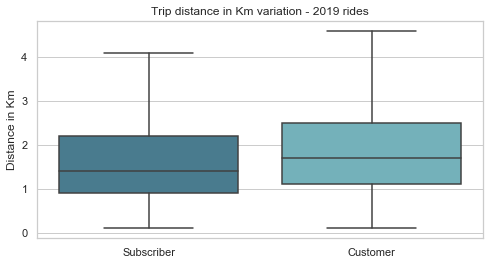

In [250]:
plt.figure(figsize = [8,4])

sns.set(style="whitegrid")
box_plot = sns.boxplot(data = df_2019, x = 'user_type', y = 'distance_km', 
            showfliers=False, palette = 'GnBu_d').set(xlabel='', 
            ylabel='Distance in Km', 
            title='Trip distance in Km variation - 2019 rides');


### Subscribers: 75% of the trips distance varies between 900m (0.56 miles) and 2.2 km (1.37 miles)
### Customers: 75% of the trips distance varies between 1.1 km (0.7 miles) and 2.5 kms (1.57 miles)

## We can see that Customers travel a bit further than Subscribers in average for trips smaller than 2.5 KMs!



## 9

# Below you see that the Subscribers' rides **durations** in average are a bit shorter than Customers'.

### Why these guys, that ride most from 8-9am, and 5-6pm are in a hurry ?! (or the customers that are in a more relaxed pace?)

(Hit DOWN key)

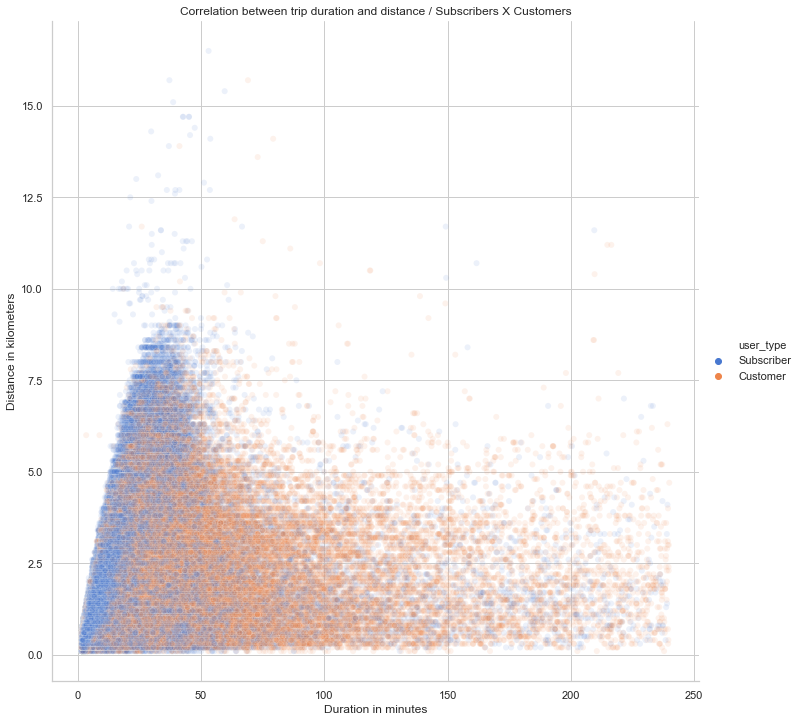

In [251]:
sns.relplot(x="duration_min", y="distance_km", alpha=.1, palette="muted", height=10, data=df_2019, hue="user_type")
plt.title('Correlation between trip duration and distance / Subscribers X Customers')
plt.ylabel('Distance in kilometers')
plt.xlabel('Duration in minutes');

# 10

# Let's see graphically the most common kind of rides:

### The darker the area, more trips with that distance and duration ranges took place:

(Hit DOWN key)

In [252]:
#Remove more outliers to improve the visualization on the "core" of the trips.
df_short = df_2019.copy()
df_short.drop(df_short[df_short.distance_km > 7].index, inplace = True) 
df_short.drop(df_short[df_short.duration_min > 45].index, inplace = True) 

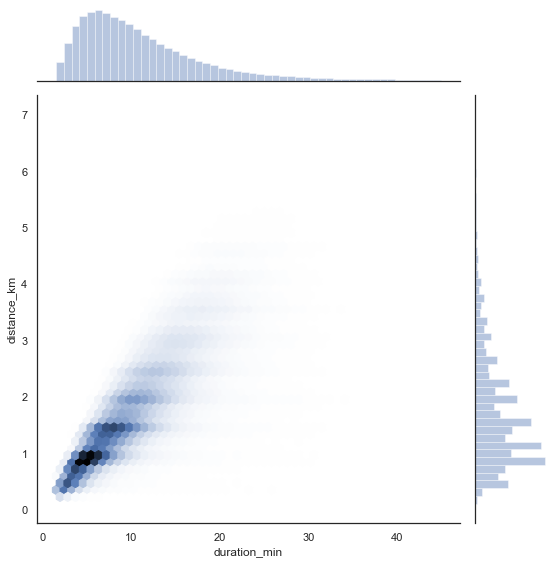

In [253]:
#hexplot to show in dark are the most frequent combinations.
with sns.axes_style("white"):
    sns.jointplot(x=df_short.duration_min, y=df_short.distance_km, kind="hex", height=8);
#plt.title('Correlation between trip duration and distance');

### The most common distances/durations are within 1km and about 5' duration (the dark blue zone). The larger the distance & duration, the less rides we have.

## It shows that the "nature" of the service are rides within that 1km / 5' range.

# It is an intesting insight to Marketing teams to target people are not customers and that do errands like that.

## 11

# Still about the the trips durations & distances, let's see it in a high-contrast mode to improve visualization:

### The lighter the area, the higher the density of the trips in such distances and durations.

(Hit DOWN key)

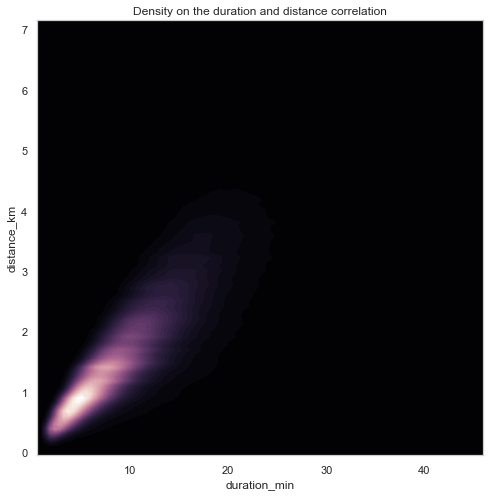

In [254]:
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df_short.duration_min, df_short.distance_km, cmap=cmap, n_levels=60, shade=True);
plt.title('Density on the duration and distance correlation');



## 12

In [255]:
df_2019.start_station_id.nunique()

427

## Last but not least...
# There are 427 stations in town.

## These are the top 20 stations where most pick-ups occurs: 

(Hit DOWN key)

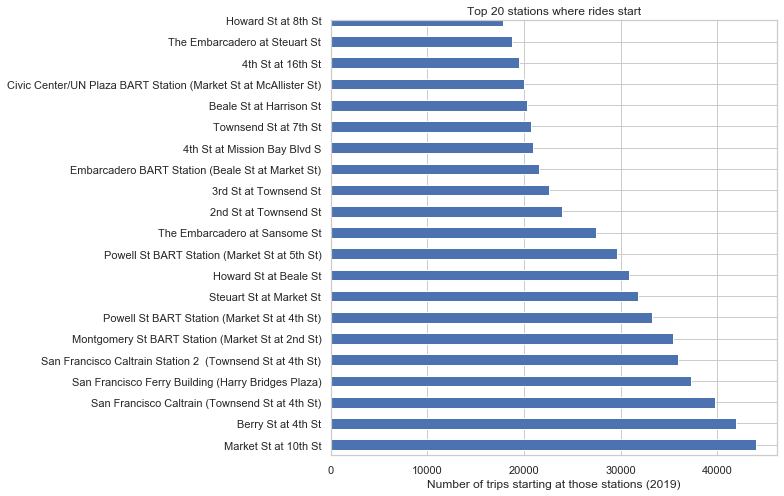

In [256]:
#Stations more used: starting stations
df_2019['start_station_name'].value_counts().plot(kind = 'barh',  figsize=(8,8));
plt.ylim(top=20);
plt.xlabel('Number of trips starting at those stations (2019)')
plt.title('Top 20 stations where rides start');

## 13

# And here are the stations where most of drop-offs occurs: 

(Hit DOWN key)

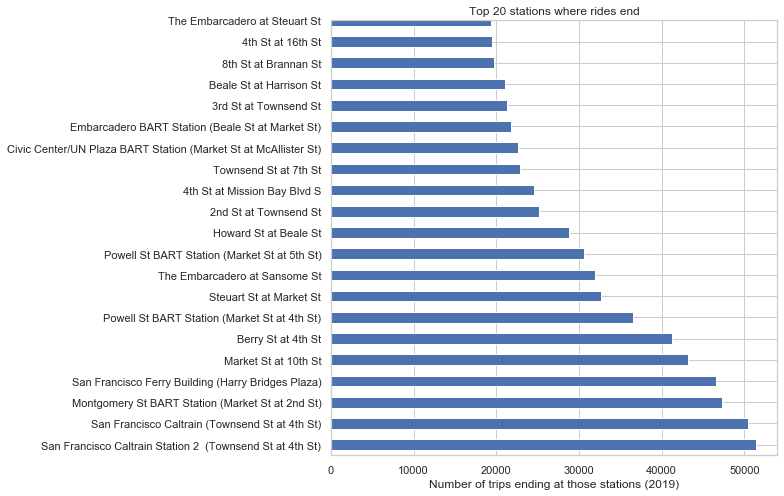

In [257]:
#Stations more used: starting stations
df_2019['end_station_name'].value_counts().plot(kind = 'barh',  figsize=(8,8));
plt.ylim(top=20);
plt.xlabel('Number of trips ending at those stations (2019)')
plt.title('Top 20 stations where rides end');

### Service management can keep a close look at them in order to indetify the need of manual bike repleshinement/withdrawal during peak hours and/or increase stations capacity.


### Thank you!

# Ride safe!




### Mauricio